## Importanto as bibliotecas:

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

import random

## Configuracoes iniciais:

In [100]:
transform = transforms.Compose([
    transforms.ToTensor()
])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.device(device)
print(device)

image_dims_color = 32*32*3
batch_size = 128

dataset = datasets.CIFAR10(root='./cifar0', train=True, transform=transform, download=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(train_dataset.dataset.data[0].shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda
Files already downloaded and verified
(32, 32, 3)


## Declarando a classe VAE e funcao de perda:

In [101]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 16, 3)
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1_mu = nn.Linear(14 * 14 * 16, 256)
        self.fc1_sig = nn.Linear(14 * 14 * 16, 256)
        self.fc2 = nn.Linear(256, 14 * 14 * 16)
        self.up_sample = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv3 = nn.ConvTranspose2d(16, 32, 3)
        self.conv4 = nn.ConvTranspose2d(32, 3, 3)
  
    def encode(self,x):
        a1 = F.relu(self.conv1(x))
        a2 = F.relu(self.conv2(a1))
        mx_poold = self.max_pool(a2)
        a_reshaped = mx_poold.reshape(-1 , 14 * 14 * 16)
        a_mu = self.fc1_mu(a_reshaped)
        a_logvar = self.fc1_sig(a_reshaped)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc2(z))
        a3 = a3.reshape(-1, 16, 14, 14)
        a3_upsample = self.up_sample(a3)
        a4 = F.relu(self.conv3(a3_upsample))
        a5 = torch.sigmoid(self.conv4(a4))
        return a5
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1,image_dims_color), x.view(-1, image_dims_color), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

## Treinamento:

In [102]:
num_epochs = 100
print_per = 100
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    loss_record = []
    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
            loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))
    torch.save(model.state_dict(), f'./epochs_vae_conv/vae_conv_epoch_{epoch + 1}.pth')

Epoch : 1 , Minibatch : 0 Loss = 278696.8750
Epoch : 1 , Minibatch : 100 Loss = 25669529.2656
Epoch : 1 , Minibatch : 200 Loss = 24546834.1719
Epoch : 1 , Minibatch : 300 Loss = 24305438.7344
Epoch 1 : Loss = (77581573.8203) 
Epoch : 2 , Minibatch : 0 Loss = 243047.6250
Epoch : 2 , Minibatch : 100 Loss = 24131575.1875
Epoch : 2 , Minibatch : 200 Loss = 24029235.0781
Epoch : 2 , Minibatch : 300 Loss = 23985704.7344
Epoch 2 : Loss = (75130629.6406) 
Epoch : 3 , Minibatch : 0 Loss = 238595.3438
Epoch : 3 , Minibatch : 100 Loss = 23834705.2969
Epoch : 3 , Minibatch : 200 Loss = 23821752.6562
Epoch : 3 , Minibatch : 300 Loss = 23751005.2969
Epoch 3 : Loss = (74372575.2812) 
Epoch : 4 , Minibatch : 0 Loss = 234548.6719
Epoch : 4 , Minibatch : 100 Loss = 23703115.0312
Epoch : 4 , Minibatch : 200 Loss = 23683235.1094
Epoch : 4 , Minibatch : 300 Loss = 23653008.9375
Epoch 4 : Loss = (73982782.5391) 
Epoch : 5 , Minibatch : 0 Loss = 237751.2188
Epoch : 5 , Minibatch : 100 Loss = 23597293.2656
Ep

## Resultados:

/tmp/ipykernel_24370/2783107970.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_100.pth'))


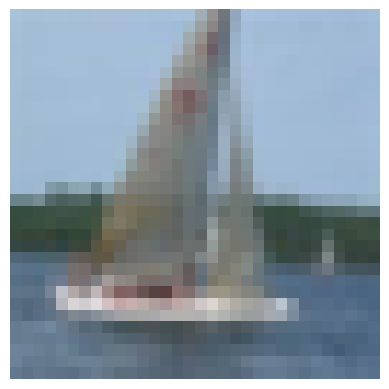

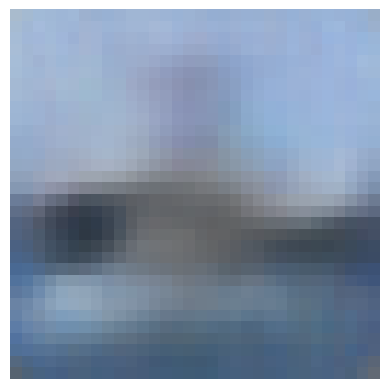

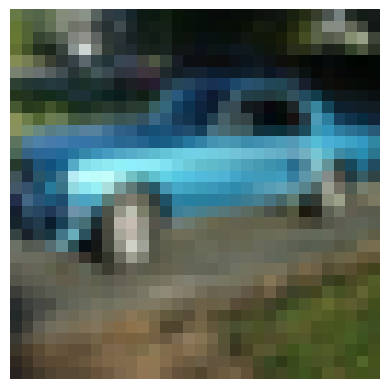

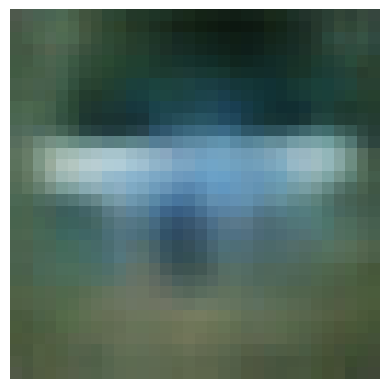

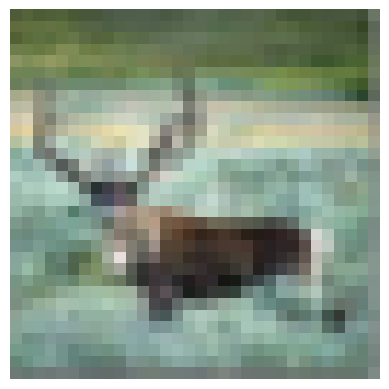

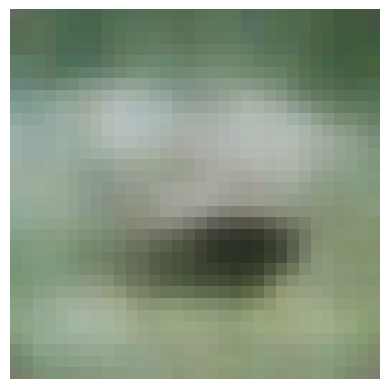

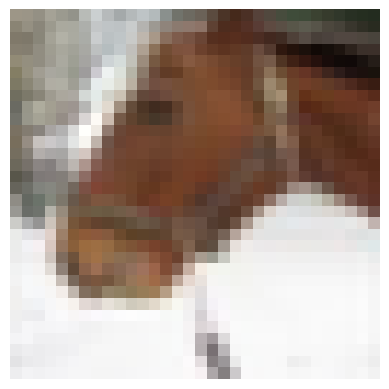

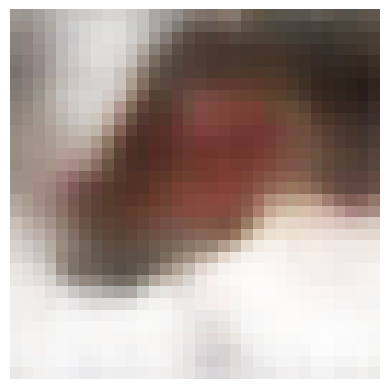

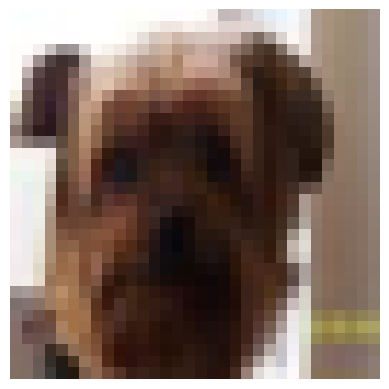

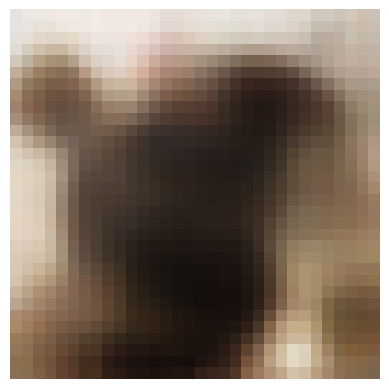

In [113]:
def generate_samples(model):
    model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_100.pth'))
    cap = 0
    limit = 5

    with torch.no_grad():
        for batch in train_loader:
            images, _ = batch
            for image in images:
                if cap >= limit: 
                    return
                image = image.unsqueeze(0).to(device)
                reconstruction, *_ = model(image)
                sample = reconstruction.squeeze().cpu().numpy()

                image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                plt.imshow(image)
                plt.axis("off")
                plt.show(block=True)

                sample = sample.transpose(1, 2, 0)
                plt.imshow(sample)
                plt.axis("off")
                plt.show(block=True)
                
                cap += 1

generate_samples(model)

/tmp/ipykernel_24370/1529299122.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_100.pth'))


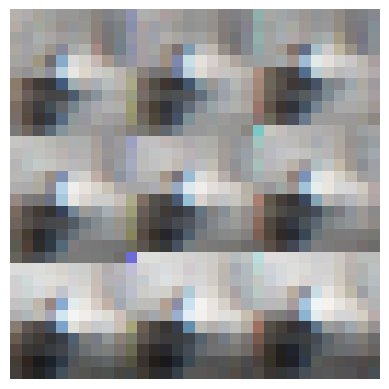

In [155]:
def generate_image(model, device):
    model = model.to(device)
    model.eval()
    model.load_state_dict(torch.load(f'./epochs_vae_conv/vae_conv_epoch_100.pth'))
    with torch.no_grad():
        z = torch.randn(1, 256).to(device)
        sample = model.decode(z)
        sample = sample.view(32, 32, 3).cpu().numpy()
        return sample

image = generate_image(model, device)
plt.imshow(image)
plt.axis('off')
plt.show(block=True)